# Reading directory

In [15]:
import os
import glob
import numpy as np


path = "./"

midi_paths = glob.glob(path + "/Dataset/**/*.mid" , recursive = True)
#midi_files


In [16]:
len(midi_paths)

18167

In [17]:
midi_files = midi_paths[0:20]

# Reading midi files

In [18]:
import pypianoroll
import random

In [19]:
%matplotlib notebook

### Compressed audios

In [20]:
# file = midi_files[125] #"chorus_symbol_key.mid"

def readMidi(file):
    pianotrack = pypianoroll.read(file)
    
    track_compressed = []
    for tracks in pianotrack:
        count=0
        tracks = tracks.binarize()
        tracks.pianoroll = np.multiply(tracks.pianoroll, 80)
        for time_stamp in tracks:
            if count % 6 ==0:
                track_compressed.append(time_stamp)
            count += 1
    track_arr = np.array(track_compressed)
    compressed=pypianoroll.StandardTrack(name='melody', program=0, is_drum=False, pianoroll=track_arr)
    return compressed
#     compressedMulti=pypianoroll.Multitrack(name=None, resolution=4, tracks=[compressed])

# Model Traning

In [21]:
pitchs = 128
in_notes = 8 # number of last notes
out_notes = 1

### Creating model

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense
#Importing ANN
generater = Sequential()

generater.add(keras.Input(shape=(pitchs*in_notes,)))
# generater.add(Dense(units = pitchs*in_notes/2, activation="sigmoid", kernel_initializer = 'uniform') )
generater.add(Dense(units = pitchs*out_notes, activation=keras.activations.softmax, kernel_initializer = 'uniform') )

generater.compile(optimizer ='adam',loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalCrossentropy()])
# generater.compile(optimizer ='adam',loss='categorical_crossentropy', metrics=['accuracy'])
generater.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
Total params: 131,200
Trainable params: 131,200
Non-trainable params: 0
_________________________________________________________________


### helper function 

In [23]:
def makeData(notes):
    y = notes[-1]
    X = notes[0:8]
    X = np.reshape(X, (pitchs*in_notes))
    return X,y

def changeScale(track):
    semitones = pypianoroll.pitch_range_tuple(track.pianoroll)
#     print(semitones)
    coin_toss = random.randint(0,1)
    if coin_toss:
        diff = semitones[0] - 36
        transpose_by = random.randint(0,abs(diff))
        compressed = track.transpose(transpose_by*-1)
    else :
        diff = 128 - semitones[1]
        transpose_by = random.randint(0,abs(diff))
        compressed = track.transpose(transpose_by*1)
#     compressed.plot()
    return compressed
    pass
    
    
# get index probablistily
def getProbIndx(note_prob):
#     temp_prob = note_prob.reshape((1,128))

    temp = np.random.choice(np.random.choice(note_prob[0], 3, p=note_prob[0], replace=False))

    indx = np.where(note_prob == temp)
    return indx #print(indx[1])

In [24]:
n = 10
midi_files = [midi_paths[i:i + n] for i in range(0, len(midi_paths), n)]
midi_files

[['.//Dataset\\midi\\a\\a-day-to-remember\\downfall-of-us-all\\intro-and-verse_symbol_key.mid',
  './/Dataset\\midi\\a\\a-day-to-remember\\downfall-of-us-all\\pre-chorus-and-chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-g-cook\\superstar\\chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-g-cook\\superstar\\pre-chorus-and-chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-g-cook\\superstar\\pre-chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\take-on-me\\chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\take-on-me\\intro-and-verse_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\take-on-me\\intro_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\take-on-me\\verse-and-pre-chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\the-sun-always-shines-on-tv\\bridge_symbol_key.mid'],
 ['.//Dataset\\midi\\a\\a-ha\\the-sun-always-shines-on-tv\\chorus_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\the-sun-always-shines-on-tv\\intro_symbol_key.mid',
  './/Dataset\\midi\\a\\a-ha\\the-sun-alw

###  Training


In [ ]:
itr=0
for files in midi_files:
    
    print(itr/len(midi_files)*100, '%')
    itr += 1
    
    for file in files:
        X_train = []
        y_train = []
#         print(file)
        try:
            compressed = readMidi(file)
        except :
#             print("faulty data")
            continue
        compressed = changeScale(compressed)
        compressed = compressed.binarize() 
        compressed = compressed.pianoroll + 0
        for i in range(0, len(compressed)-8):
            X, y  = makeData(compressed[i: i+10])
            X_train.append(X)
            y_train.append(y)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        try:
            generater.fit(X_train,y_train,epochs=100, use_multiprocessing=True, verbose=0)
        except :
    #             print("faulty data")
            continue

0.0 %
0.0550357732526142 %
0.1100715465052284 %
0.1651073197578426 %
0.2201430930104568 %
0.27517886626307103 %
0.3302146395156852 %
0.3852504127682994 %
0.4402861860209136 %
0.49532195927352773 %


In [ ]:
loaded_model = keras.models.load_model("Fully trained.h5")
loaded_model.summary()

### Prediction

In [430]:
import random
# track = compressed[0:8]

seed_notes = random.sample(midi_paths, 1)
# print(seed_notes)
track = readMidi(seed_notes[0])
track = track.binarize() 
track = track.pianoroll + 0
track = track[0:8]
steps = 492
# print(track)

# track[-8:]

seed, temp = makeData(track[-8:])
[[]]
[]

seed = np.reshape(seed, (-1, 1024))
# print(len(seed))
seed

count = 0
for i in range(0, steps):
    seed, temp = makeData(track[-8:])
    seed = np.reshape(seed, (-1, 1024))
    
    note_prob = generater.predict(seed)
#     print(note_prob.shape)
#     print(np.random.choice(note_prob[0], 5, p=note_prob))
    if count%8:
        new_note = np.argmax(note_prob, axis=1)
    else:
#         temp = random.randint(0,4)
#         if temp!=0:
        new_note = getProbIndx(note_prob)
    new_step = np.arange(128)
    new_step = np.zeros_like(new_step, dtype=np.uint8)
    new_step[new_note[-1]] = 1
    track =np.append(track, [new_step], axis=0)
    count += 1
#     track = np.append(new_step, track)
# track[9]

### Writing generated music

In [431]:
def shift(track):
    s = 0
    for x in track:
#         print(x)
        s += np.argmax(note_prob, axis=1)[0]
#     print(s/len(track))
    
    rescale = 66- (s/len(track))
    track.transpose(int(rescale))

In [432]:
track = np.multiply(track, 80)

In [433]:
new_track=pypianoroll.StandardTrack(name='melody', program=0, is_drum=False, pianoroll=track)

<IPython.core.display.Javascript object>


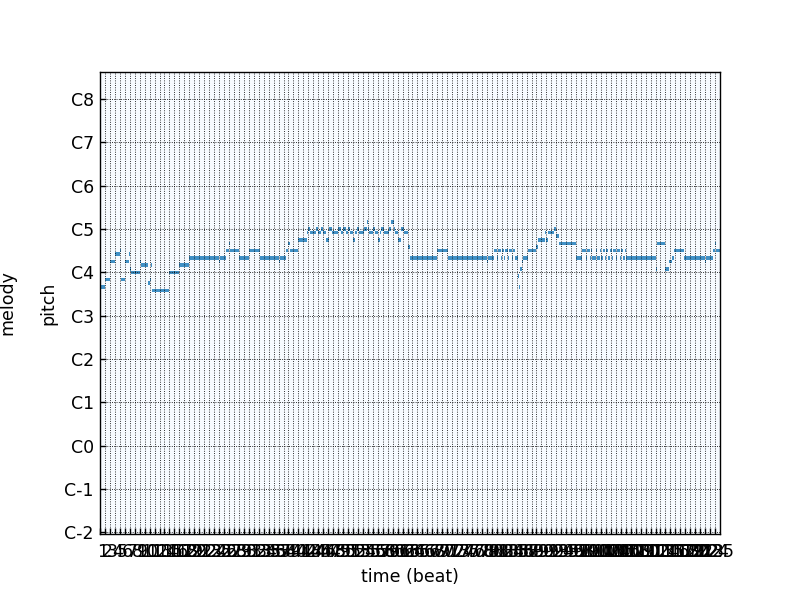

[<AxesSubplot:xlabel='time (beat)', ylabel='melody\n\npitch'>]

In [434]:
newMulti = pypianoroll.Multitrack(name=None, resolution=4, tracks=[new_track])
newMulti.plot()

In [428]:

shift(new_track)

# print(note_prob)


<IPython.core.display.Javascript object>


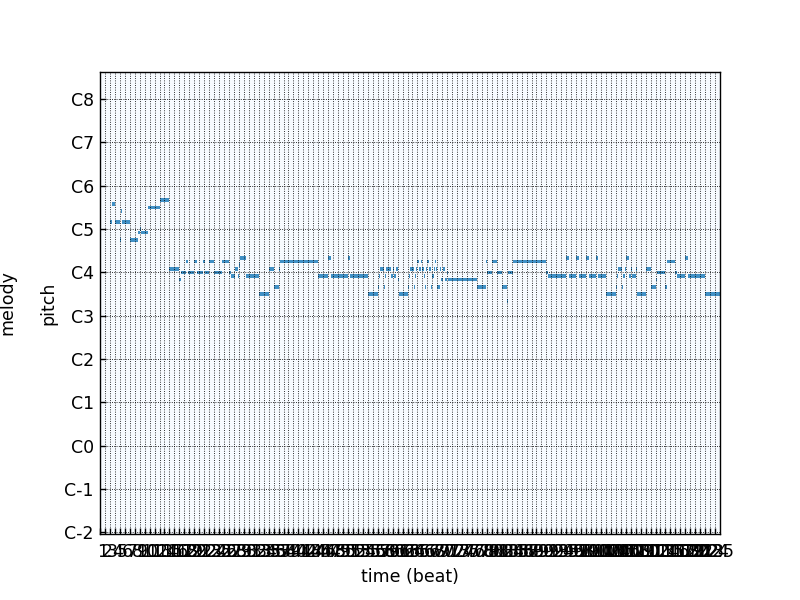

[<AxesSubplot:xlabel='time (beat)', ylabel='melody\n\npitch'>]

In [429]:

newMulti = pypianoroll.Multitrack(name=None, resolution=4, tracks=[new_track])
newMulti.plot()

In [436]:

pypianoroll.write("first_gen.mid", newMulti)

#### trys

<IPython.core.display.Javascript object>


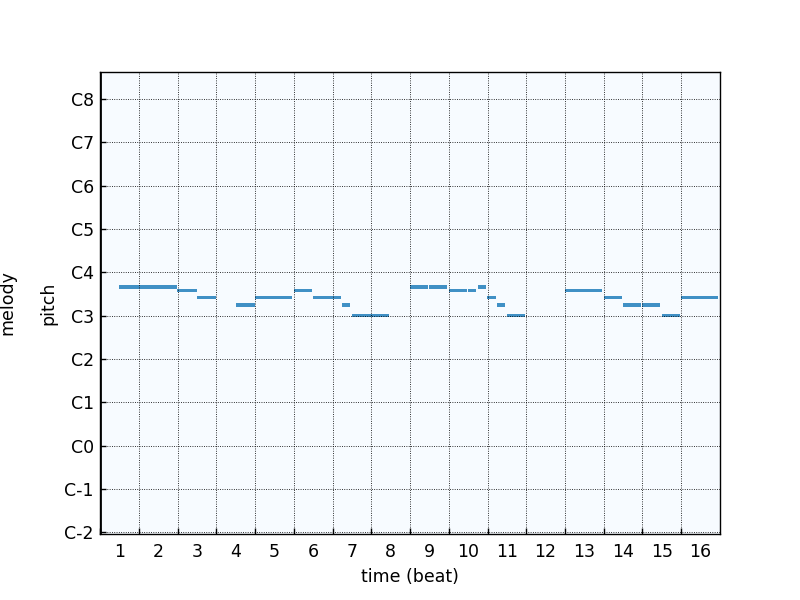

[<AxesSubplot:xlabel='time (beat)', ylabel='melody\n\npitch'>]

In [68]:
file = random.sample(midi_paths, 1)
try:
    compressed = pypianoroll.read(file[0])
except :
#             print("faulty data")
    print("shit")
compressed.plot()
# compressed = changeScale(compressed)
# compressed = compressed.binarize()
# compressed.plot()
# compressed = compressed.pianoroll + 0
